In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install pytorchcv

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
import torch.optim as optim
import os, pickle, time, copy, glob
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import argparse
import json
from pytorchcv.model_provider import get_model as ptcv_get_model
from math import sqrt
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

trans = ['train_transforms','test_transforms']
path = "/content/gdrive/My Drive/Colab Notebooks/MainDataAug/"
categories = ['train','test']

In [ ]:
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}


In [ ]:

len_train = len(dset['train'])
print('original train dataset size ', len_train) 
len_test = len(dset['test'])
print('original test dataset size ', len_test) 

indices_list = range(len_train)
indices = [*indices_list]


np.random.shuffle(indices)
#Splitting the indices based on train and val percentage
split = int(np.floor(0.2 * len_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('Upadted train dataset size:', len(train_idx))
print('Created validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(dset['test']))]
print('the test imagedataest size', len(dset['test']))

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {}
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['test'] = test_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()
print(dataset_sizes['val'], dataset_sizes['test'], dataset_sizes['train'])


original train dataset size  3847
original test dataset size  3040
Upadted train dataset size: 3078
Created validation dataset size: 769
the test imagedataest size 3040
769 3040 3078


In [ ]:

train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16,
    drop_last= True, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16, 
    drop_last= True, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=16, 
    drop_last= True,sampler=test_sampler,num_workers=0)


In [ ]:
dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
class_names = dset['train'].classes

In [ ]:
images, labels = next(iter(dataloaders['test']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()]))

label: 0, class: covid-n


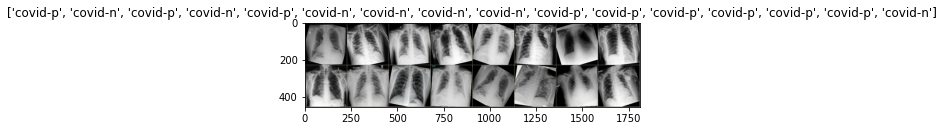

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs,classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
class_names = dset["train"].classes
imshow(out, title = [class_names[x] for x in classes])


In [ ]:
class ModelZfnet(nn.Module):
    def __init__(self):
        super(ModelZfnet, self).__init__()
        self.model = ptcv_get_model("zfnet", pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.output.fc3= nn.Sequential(
        nn.Linear(4096, 2),
        nn.LogSoftmax(dim=1))

           

    def forward(self, x):
        return self.model(x)
        

model = ModelZfnet()

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []
def fit(self, dataloaders, num_epochs):


        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()  
                else:
                    self.model.eval()   
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()
                    

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)


                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if(phase == 'train'):
                  train_losses.append(epoch_loss)   
                  train_acc.append(epoch_acc) 
                if(phase == 'val'):
                  val_losses.append(epoch_loss)   
                  val_acc.append(epoch_acc) 

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        

        self.model.load_state_dict(best_model_wts)
        return self.model


In [ ]:
num_epochs = 5
model1_zfnet = fit(model, dataloaders, num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6923 Acc: 0.8752
val Loss: 0.1740 Acc: 0.9441
Epoch 1/4
----------
train Loss: 0.3756 Acc: 0.9243
val Loss: 0.2178 Acc: 0.9506
Epoch 2/4
----------
train Loss: 0.4797 Acc: 0.9227
val Loss: 0.1126 Acc: 0.9753
Epoch 3/4
----------
train Loss: 0.3656 Acc: 0.9402
val Loss: 0.0745 Acc: 0.9857
Epoch 4/4
----------
train Loss: 0.3409 Acc: 0.9461
val Loss: 0.0919 Acc: 0.9870
Training complete in 26m 40s
Best val Acc: 0.986996


In [ ]:
model1_zfnet.eval()
torch.save(model1_zfnet, '/content/gdrive/My Drive/Colab Notebooks/zfnet_model1_with_aug.pt')

In [ ]:
num_epochs = 10
model2_zfnet = fit(model, dataloaders, num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5851 Acc: 0.9246
val Loss: 0.8934 Acc: 0.8869
Epoch 1/9
----------
train Loss: 0.4826 Acc: 0.9470
val Loss: 0.0665 Acc: 0.9844
Epoch 2/9
----------


In [ ]:
model2_zfnet.eval()
torch.save(model2_zfnet, '/content/gdrive/My Drive/Colab Notebooks/zfnet_model2_with_aug.pt')

In [ ]:
num_epochs = 15
model3_zfnet = fit(model, dataloaders, num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7225 Acc: 0.9360
val Loss: 0.0958 Acc: 0.9831
Epoch 1/14
----------
train Loss: 0.5767 Acc: 0.9448
val Loss: 0.1023 Acc: 0.9831
Epoch 2/14
----------
train Loss: 0.7102 Acc: 0.9344
val Loss: 0.0542 Acc: 0.9870
Epoch 3/14
----------
train Loss: 0.5192 Acc: 0.9548
val Loss: 0.0539 Acc: 0.9857
Epoch 4/14
----------
train Loss: 0.3639 Acc: 0.9643
val Loss: 0.0846 Acc: 0.9922
Epoch 5/14
----------
train Loss: 0.5127 Acc: 0.9565
val Loss: 0.1469 Acc: 0.9883
Epoch 6/14
----------
train Loss: 0.4002 Acc: 0.9591
val Loss: 0.1243 Acc: 0.9857
Epoch 7/14
----------
train Loss: 0.3917 Acc: 0.9613
val Loss: 0.0480 Acc: 0.9909
Epoch 8/14
----------
train Loss: 0.5791 Acc: 0.9522
val Loss: 0.0931 Acc: 0.9870
Epoch 9/14
----------
train Loss: 0.4472 Acc: 0.9574
val Loss: 0.1458 Acc: 0.9883
Epoch 10/14
----------
train Loss: 0.4306 Acc: 0.9555
val Loss: 0.0586 Acc: 0.9935
Epoch 11/14
----------
train Loss: 0.3848 Acc: 0.9623
val Loss: 0.0673 Acc: 0.9922
Epoch 12/14
----------
train Loss: 0

In [ ]:
model3_zfnet.eval()
torch.save(model3_zfnet, '/content/gdrive/My Drive/Colab Notebooks/zfnet_model3_with_aug.pt')

In [ ]:
num_epochs = 20
model4_zfnet = fit(model, dataloaders, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7312 Acc: 0.9399
val Loss: 0.1016 Acc: 0.9896
Epoch 1/19
----------
train Loss: 0.4933 Acc: 0.9519
val Loss: 0.1413 Acc: 0.9883
Epoch 2/19
----------
train Loss: 0.5907 Acc: 0.9509
val Loss: 0.2393 Acc: 0.9805
Epoch 3/19
----------
train Loss: 0.6138 Acc: 0.9545
val Loss: 0.1646 Acc: 0.9831
Epoch 4/19
----------
train Loss: 0.4859 Acc: 0.9600
val Loss: 0.1193 Acc: 0.9909
Epoch 5/19
----------
train Loss: 0.4333 Acc: 0.9639
val Loss: 0.0772 Acc: 0.9909
Epoch 6/19
----------
train Loss: 0.4206 Acc: 0.9610
val Loss: 0.1049 Acc: 0.9896
Epoch 7/19
----------
train Loss: 0.5404 Acc: 0.9539
val Loss: 0.1013 Acc: 0.9922
Epoch 8/19
----------
train Loss: 0.4752 Acc: 0.9574
val Loss: 0.1547 Acc: 0.9870
Epoch 9/19
----------
train Loss: 0.4366 Acc: 0.9610
val Loss: 0.0477 Acc: 0.9922
Epoch 10/19
----------
train Loss: 0.4367 Acc: 0.9591
val Loss: 0.1562 Acc: 0.9896
Epoch 11/19
----------
train Loss: 0.4879 Acc: 0.9597
val Loss: 0.0963 Acc: 0.9896
Epoch 12/19
----------
train Loss: 0

In [ ]:
model4_zfnet.eval()
torch.save(model4_zfnet, '/content/gdrive/My Drive/Colab Notebooks/zfnet_model4_with_aug.pt')

In [ ]:
num_epochs = 25
model5_zfnet = fit(model, dataloaders, num_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5187 Acc: 0.9545
val Loss: 0.0692 Acc: 0.9896
Epoch 1/24
----------
train Loss: 0.7032 Acc: 0.9477
val Loss: 0.1922 Acc: 0.9857
Epoch 2/24
----------
train Loss: 0.6496 Acc: 0.9558
val Loss: 0.0846 Acc: 0.9896
Epoch 3/24
----------
train Loss: 0.7001 Acc: 0.9483
val Loss: 0.1035 Acc: 0.9896
Epoch 4/24
----------
train Loss: 0.5631 Acc: 0.9539
val Loss: 0.0886 Acc: 0.9896
Epoch 5/24
----------
train Loss: 0.5084 Acc: 0.9604
val Loss: 0.0889 Acc: 0.9922
Epoch 6/24
----------
train Loss: 0.5772 Acc: 0.9565
val Loss: 0.1093 Acc: 0.9922
Epoch 7/24
----------
train Loss: 0.5789 Acc: 0.9565
val Loss: 0.1046 Acc: 0.9909
Epoch 8/24
----------
train Loss: 0.4468 Acc: 0.9617
val Loss: 0.1289 Acc: 0.9883
Epoch 9/24
----------
train Loss: 0.4588 Acc: 0.9607
val Loss: 0.1468 Acc: 0.9896
Epoch 10/24
----------
train Loss: 0.4761 Acc: 0.9607
val Loss: 0.1073 Acc: 0.9935
Epoch 11/24
----------
train Loss: 0.4968 Acc: 0.9574
val Loss: 0.1100 Acc: 0.9909
Epoch 12/24
----------
train Loss: 0

In [ ]:
model5_zfnet.eval()
torch.save(model5_zfnet, '/content/gdrive/My Drive/Colab Notebooks/zfnet_model5_with_aug.pt')